KNN — MobileNetV2 Embeddings + PCA
Detected classes (5): ['1. Tea algal leaf spot', '2. Brown Blight', '4. Helopeltis', '5. Red spider', '7. Healthy leaf']
Train: 2000 | Val: 298 | Test: 597

Loading images...

Extracting embeddings...
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 272ms/step
Train embeddings: (2000, 1280)
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step
Val embeddings: (298, 1280)
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step
Test embeddings: (597, 1280)

Standardize + PCA (fit on train only)
PCA dims: 517 (explained var: 0.9501)

Data ready for KNN.

GridSearchCV (5-fold) on training set...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best params: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best CV accuracy: 0.7390
Validation accuracy (best KNN): 0.7081

Test Performance (KNN on embeddings+PCA):
  Accuracy : 0.7253
  Precision: 0.6970 [macro]
  Recall   : 0.6699 [macro]
  F1-score : 0.6755 [macro]

Per-class report:
                        precision    recal

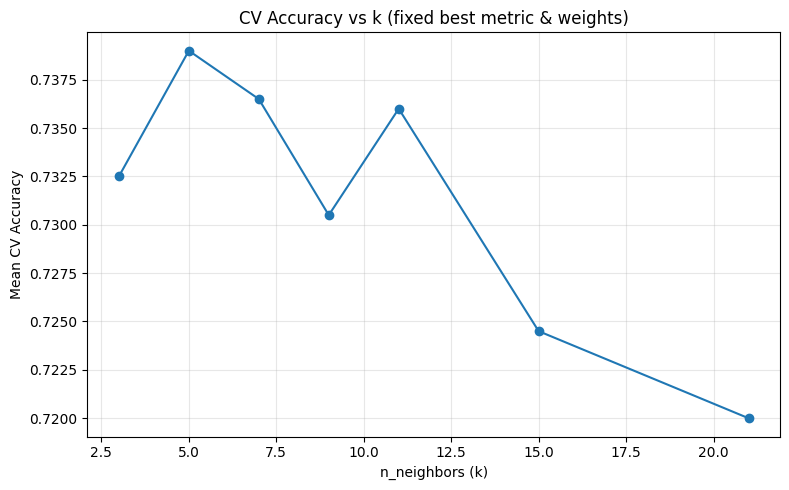

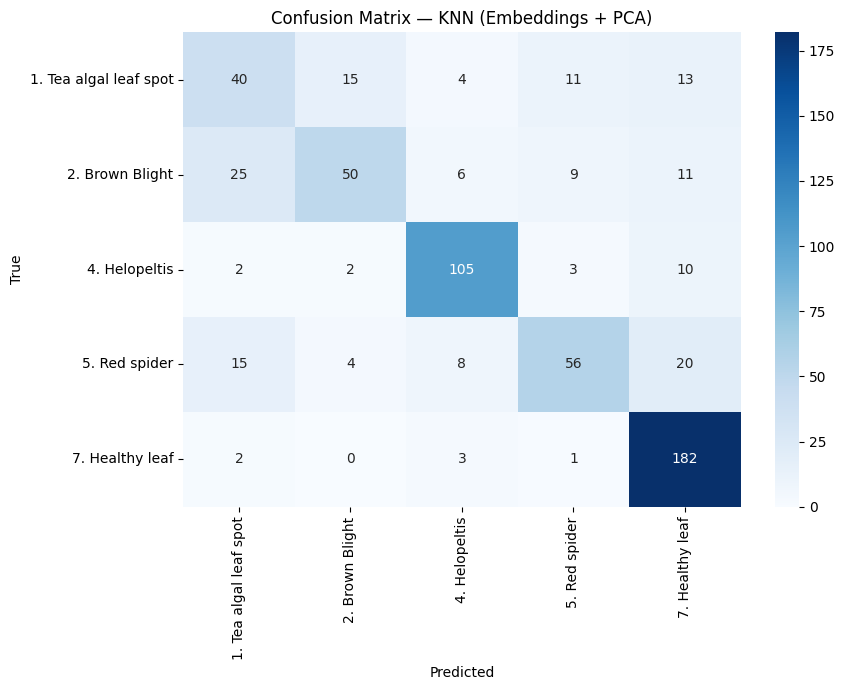

<Figure size 1000x500 with 0 Axes>

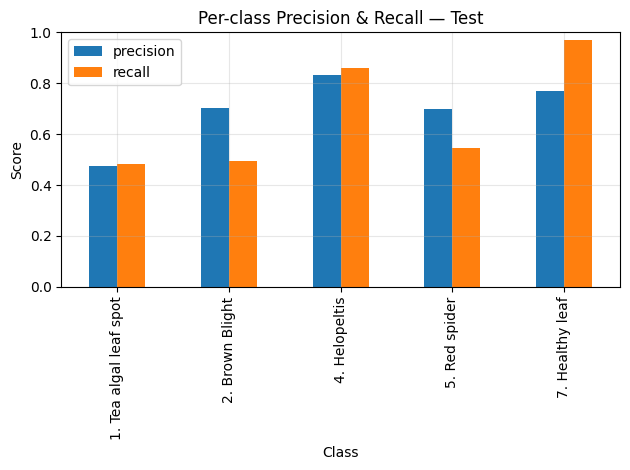


5-Fold CV verification (Train+Val) with best params...
Fold 1: 0.7391
Fold 2: 0.7022
Fold 3: 0.7348
Fold 4: 0.7124
Fold 5: 0.7625
CV mean acc: 0.7302 ± 0.0212

Saving results and model...
✓ Saved: knn_embeddings_pca_results_summary.csv
✓ Saved: knn_gridsearch_cv_results.csv
✓ Saved: knn_per_class_precision_recall.csv
✓ Saved: scaler.joblib, pca.joblib, knn_final_model.joblib

Done ✅


In [2]:
# ==============================================================
# TEA LEAF DISEASE DETECTION — KNN (MobileNetV2 Embeddings + PCA)
# Full 13-step pipeline:
#   - Frozen MobileNetV2 feature extraction
#   - Standardization + PCA (fit on train only)
#   - GridSearchCV (5-fold) for KNN hyperparameters
#   - Test evaluation (accuracy, precision, recall, f1)
#   - Plots: CV curve, confusion matrix, per-class precision/recall bars
#   - Extra 5-fold CV verification with best params
#   - Save results to CSV + persist model
# ==============================================================

import os, glob, random, gc, json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score)

import joblib

# ==============================================================
# STEP 1: SETUP
# ==============================================================
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

DATA_ROOT = "/Users/tharukakumarasiri/Desktop/new model training/Final_preprocessed_Dataset"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

IMG_H, IMG_W = 224, 224
BATCH_SIZE = 32

print("="*72)
print("KNN — MobileNetV2 Embeddings + PCA")
print("="*72)

# ==============================================================
# STEP 2: LOAD IMAGE PATHS & LABELS
# ==============================================================
def gather_paths_and_labels(root_dir):
    paths, labels = [], []
    for cls in sorted(os.listdir(root_dir)):
        cls_dir = os.path.join(root_dir, cls)
        if os.path.isdir(cls_dir):
            for p in glob.glob(os.path.join(cls_dir, "*.jpg")):
                paths.append(p)
                labels.append(cls)
    return paths, labels

class_names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
print(f"Detected classes ({len(class_names)}): {class_names}")

train_paths, train_labels = gather_paths_and_labels(TRAIN_DIR)
val_paths,   val_labels   = gather_paths_and_labels(VAL_DIR)
test_paths,  test_labels  = gather_paths_and_labels(TEST_DIR)

le = LabelEncoder().fit(class_names)
y_train = le.transform(train_labels)
y_val   = le.transform(val_labels)
y_test  = le.transform(test_labels)
NUM_CLASSES = len(class_names)

print(f"Train: {len(train_paths)} | Val: {len(val_paths)} | Test: {len(test_paths)}")

# ==============================================================
# STEP 3: LOAD & PREPROCESS IMAGES (224×224 RGB → [0,1])
# ==============================================================
def load_images(paths):
    X = np.empty((len(paths), IMG_H, IMG_W, 3), dtype=np.float32)
    for i, path in enumerate(paths):
        img = Image.open(path).convert("RGB").resize((IMG_W, IMG_H))
        X[i] = np.asarray(img, dtype=np.float32) / 255.0
    return X

print("\nLoading images...")
X_train_img = load_images(train_paths)
X_val_img   = load_images(val_paths)
X_test_img  = load_images(test_paths)

# ==============================================================
# STEP 4: FEATURE EXTRACTION (Frozen MobileNetV2, global avg pool)
# ==============================================================
backbone = MobileNetV2(weights="imagenet", include_top=False, pooling="avg",
                       input_shape=(IMG_H, IMG_W, 3))
backbone.trainable = False

def extract_embeddings(model, X, msg=""):
    X_prep = mobilenet_preprocess((X * 255.).astype(np.float32))
    feats = model.predict(X_prep, batch_size=BATCH_SIZE, verbose=1)
    print(f"{msg} embeddings: {feats.shape}")
    return feats

print("\nExtracting embeddings...")
X_train_emb = extract_embeddings(backbone, X_train_img, "Train")
X_val_emb   = extract_embeddings(backbone, X_val_img,   "Val")
X_test_emb  = extract_embeddings(backbone, X_test_img,  "Test")
EMB_DIM = X_train_emb.shape[1]

# Free image tensors (we only keep embeddings)
del X_train_img, X_val_img, X_test_img
gc.collect()

# ==============================================================
# STEP 5: STANDARDIZATION + PCA (fit on train only)
# ==============================================================
print("\nStandardize + PCA (fit on train only)")
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_std = scaler.fit_transform(X_train_emb)
X_val_std   = scaler.transform(X_val_emb)
X_test_std  = scaler.transform(X_test_emb)

# Keep PCA ratio for flexibility; adjust if you want a fixed dim (e.g., 256)
PCA_COMPONENTS = 0.95
pca = PCA(n_components=PCA_COMPONENTS, random_state=42)

X_train_pca = pca.fit_transform(X_train_std)
X_val_pca   = pca.transform(X_val_std)
X_test_pca  = pca.transform(X_test_std)

print(f"PCA dims: {X_train_pca.shape[1]} (explained var: {pca.explained_variance_ratio_.sum():.4f})")

# ==============================================================
# STEP 6: PACK DATA (train/val/test ready)
# ==============================================================
# (Already packed as *_pca with integer labels y_train / y_val / y_test)
print("\nData ready for KNN.")

# ==============================================================
# STEP 7: DEFINE KNN & HYPERPARAMETER SPACE
# ==============================================================
knn = KNeighborsClassifier()

param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

# We’ll grid-search on TRAIN set, validate on a held-out internal CV (5-fold)
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==============================================================
# STEP 8: GRIDSEARCHCV (5-FOLD CV) — FIND BEST HYPERPARAMS
# ==============================================================
print("\nGridSearchCV (5-fold) on training set...")
# To avoid leakage: grid-search on X_train_pca / y_train only.
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring={"acc": "accuracy", "f1_macro": "f1_macro"},
    refit="acc",
    cv=cv5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)
grid.fit(X_train_pca, y_train)

print(f"Best params: {grid.best_params_}")
print(f"Best CV accuracy: {grid.best_score_:.4f}")

# ==============================================================
# STEP 9: FIT BEST MODEL (TRAIN + VAL) AND EVALUATE ON VAL/TEST
# ==============================================================
# Evaluate best estimator on the held-out validation set
best_knn = grid.best_estimator_
val_pred = best_knn.predict(X_val_pca)
val_acc  = accuracy_score(y_val, val_pred)
print(f"Validation accuracy (best KNN): {val_acc:.4f}")

# Optionally refit on (train + val) before final test evaluation
X_trval = np.vstack([X_train_pca, X_val_pca])
y_trval = np.concatenate([y_train, y_val])

final_knn = KNeighborsClassifier(**grid.best_params_)
final_knn.fit(X_trval, y_trval)

# ==============================================================
# STEP 10: TEST EVALUATION (ACC, PREC, REC, F1)
# ==============================================================
y_pred = final_knn.predict(X_test_pca)
test_acc  = accuracy_score(y_test, y_pred)
test_prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
test_rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
test_f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\nTest Performance (KNN on embeddings+PCA):")
print(f"  Accuracy : {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f} [macro]")
print(f"  Recall   : {test_rec:.4f} [macro]")
print(f"  F1-score : {test_f1:.4f} [macro]")

print("\nPer-class report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4, zero_division=0))

# ==============================================================
# STEP 11: VISUALIZATION — CV CURVE, CONFUSION MATRIX, PR BARS
# ==============================================================
# 11a) CV curve: mean CV accuracy vs k (for a fixed metric & weights = best)
cv_results = pd.DataFrame(grid.cv_results_)
mask = (cv_results["param_metric"] == grid.best_params_["metric"]) & \
       (cv_results["param_weights"] == grid.best_params_["weights"])
subset = cv_results[mask].copy()
subset.sort_values("param_n_neighbors", inplace=True)

plt.figure(figsize=(8,5))
plt.plot(subset["param_n_neighbors"], subset["mean_test_acc"], marker="o")
plt.title("CV Accuracy vs k (fixed best metric & weights)")
plt.xlabel("n_neighbors (k)")
plt.ylabel("Mean CV Accuracy")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 11b) Confusion Matrix (test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — KNN (Embeddings + PCA)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# 11c) Per-class Precision & Recall bars (test)
report = classification_report(y_test, y_pred, target_names=class_names,
                               output_dict=True, zero_division=0)
per_class = pd.DataFrame(report).T.loc[class_names, ["precision", "recall"]]

plt.figure(figsize=(10,5))
per_class.plot(kind="bar")
plt.title("Per-class Precision & Recall — Test")
plt.xlabel("Class"); plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ==============================================================
# STEP 12: EXTRA 5-FOLD CV VERIFICATION (Train+Val, best params)
# ==============================================================
print("\n5-Fold CV verification (Train+Val) with best params...")
skf2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
for fold, (tr_idx, va_idx) in enumerate(skf2.split(X_trval, y_trval), 1):
    clf = KNeighborsClassifier(**grid.best_params_)
    clf.fit(X_trval[tr_idx], y_trval[tr_idx])
    val_acc2 = clf.score(X_trval[va_idx], y_trval[va_idx])
    print(f"Fold {fold}: {val_acc2:.4f}")
    cv_scores.append(val_acc2)

cv_mean = float(np.mean(cv_scores))
cv_std  = float(np.std(cv_scores))
print(f"CV mean acc: {cv_mean:.4f} ± {cv_std:.4f}")

# ==============================================================
# STEP 13: SAVE ARTIFACTS (CSV + MODEL)
# ==============================================================
print("\nSaving results and model...")

# Save main summary
summary_df = pd.DataFrame({
    "Model": ["KNN_on_MobileNetV2_Embeddings_PCA"],
    "Best_Params": [json.dumps(grid.best_params_)],
    "Val_Accuracy_BestKNN": [float(val_acc)],
    "Test_Accuracy": [float(test_acc)],
    "Test_Precision_Macro": [float(test_prec)],
    "Test_Recall_Macro": [float(test_rec)],
    "Test_F1_Macro": [float(test_f1)],
    "CV_Mean_Acc_TrainOnly": [float(grid.best_score_)],
    "CV_Mean_Acc_TrainVal": [cv_mean],
    "CV_Std_TrainVal": [cv_std],
    "PCA_Dim": [X_train_pca.shape[1]],
    "Explained_Var": [float(pca.explained_variance_ratio_.sum())]
})
summary_df.to_csv("knn_embeddings_pca_results_summary.csv", index=False)

# Save full GridSearch results
cv_results_out = cv_results.copy()
cv_results_out.to_csv("knn_gridsearch_cv_results.csv", index=False)

# Save per-class metrics
per_class_out = per_class.copy()
per_class_out.to_csv("knn_per_class_precision_recall.csv")

# Persist preprocessing & model
joblib.dump(scaler, "scaler.joblib")
joblib.dump(pca, "pca.joblib")
joblib.dump(final_knn, "knn_final_model.joblib")

print("✓ Saved: knn_embeddings_pca_results_summary.csv")
print("✓ Saved: knn_gridsearch_cv_results.csv")
print("✓ Saved: knn_per_class_precision_recall.csv")
print("✓ Saved: scaler.joblib, pca.joblib, knn_final_model.joblib")
print("\nDone ✅")

ENHANCED KNN — MobileNetV2 Embeddings + PCA(0.99) + Cosine Distance
Detected classes (5): ['1. Tea algal leaf spot', '2. Brown Blight', '4. Helopeltis', '5. Red spider', '7. Healthy leaf']
Train: 2000 | Val: 298 | Test: 597

Loading images...

Extracting embeddings...
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 284ms/step
Train embeddings: (2000, 1280)
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step
Val embeddings: (298, 1280)
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step
Test embeddings: (597, 1280)

Normalizing + PCA (retain 99% variance)...
PCA dims: 773 (explained variance: 0.9900)

Running GridSearchCV (5-fold)...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best Params: {'metric': 'cosine', 'n_neighbors': 11, 'weights': 'distance'}
Best CV Accuracy: 0.7680

Final Test Performance — Enhanced KNN
Accuracy : 0.7454
Precision: 0.7166
Recall   : 0.7025
F1-score : 0.7027


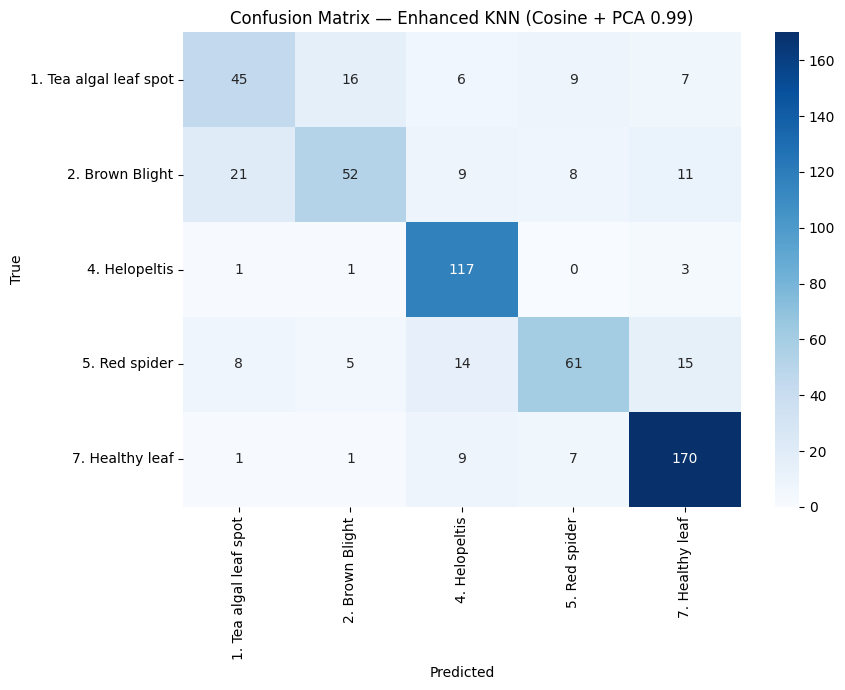

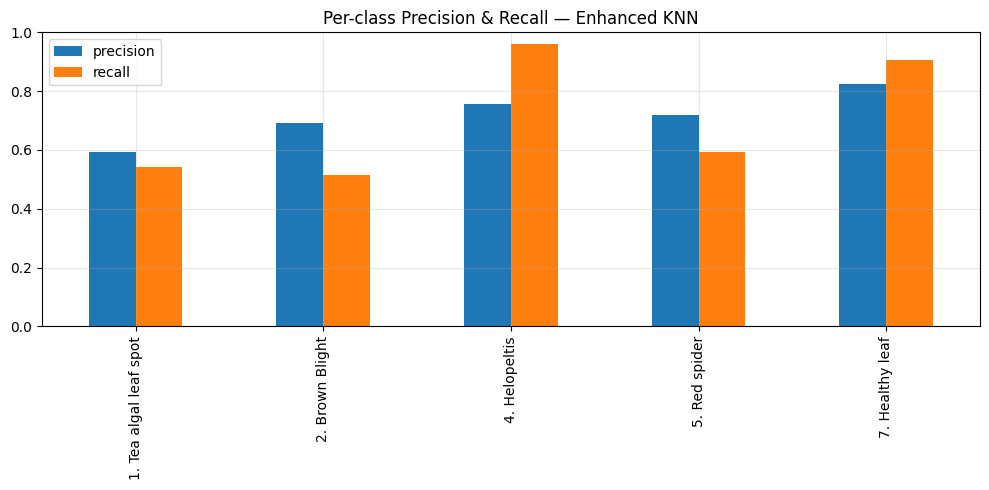


Computing mean CV accuracy vs k with best metric/weights...

CV Accuracy by k (best metric & weights):
    k  cv_mean_acc    cv_std
0   3       0.7630  0.025417
1   5       0.7565  0.015460
2   7       0.7610  0.010198
3   9       0.7650  0.023822
4  11       0.7680  0.023527
5  15       0.7565  0.018480
6  21       0.7570  0.019900


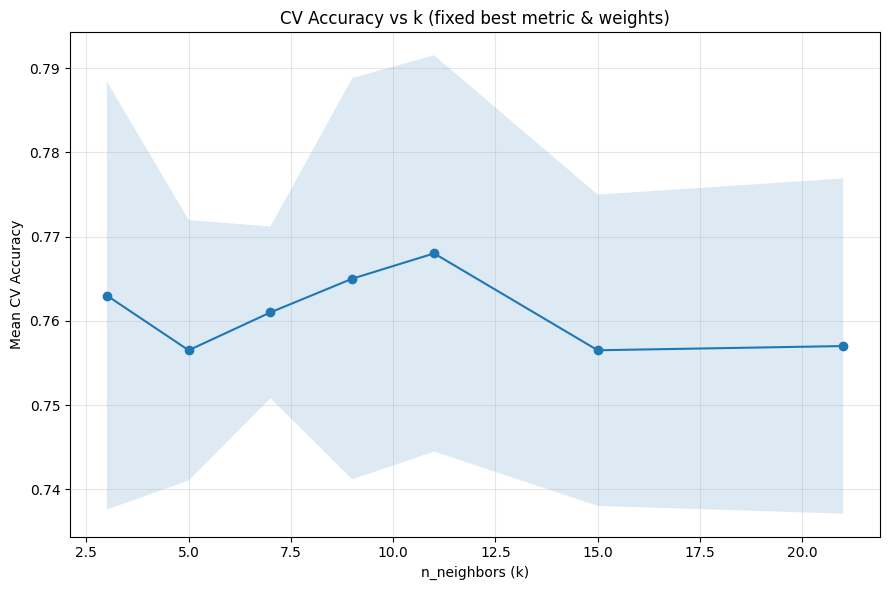


Benchmark: PCA vs No-PCA (subset for speed)...
Subset accuracy (No PCA): 0.7152

✅ Saved:
  • enhanced_knn_results.csv
  • enhanced_knn_cv_k_curve.csv
  • enhanced_knn_model.joblib
  • enhanced_pca.joblib

Done ✅


In [4]:
# ==============================================================
# TEA LEAF DISEASE DETECTION — ENHANCED KNN (MobileNetV2 Embeddings)
# Full 13-step pipeline:
#   1) Paths & labels
#   2) Load images
#   3) MobileNetV2 embeddings
#   4) Normalize + PCA(0.99)
#   5) GridSearchCV (euclidean/manhattan/cosine)
#   6) Train best model (train+val)
#   7) Test evaluation (Acc/Prec/Rec/F1)
#   8) Confusion matrix + per-class PR
#   9) CV accuracy vs k (mean across folds)  <-- ADDED
#  10) PCA vs No-PCA benchmark
#  11) Save CSVs & models
# ==============================================================

import os, glob, random, gc, json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score)
import joblib

# --------------------------------------------------------------
# STEP 1: SETUP
# --------------------------------------------------------------
np.random.seed(42); tf.random.set_seed(42); random.seed(42)

DATA_ROOT = "/Users/tharukakumarasiri/Desktop/new model training/Final_preprocessed_Dataset"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

IMG_H, IMG_W = 224, 224
BATCH_SIZE = 32

print("="*74)
print("ENHANCED KNN — MobileNetV2 Embeddings + PCA(0.99) + Cosine Distance")
print("="*74)

# --------------------------------------------------------------
# STEP 2: LOAD IMAGE PATHS & LABELS
# --------------------------------------------------------------
def gather_paths_and_labels(root_dir):
    paths, labels = [], []
    for cls in sorted(os.listdir(root_dir)):
        cls_dir = os.path.join(root_dir, cls)
        if os.path.isdir(cls_dir):
            for p in glob.glob(os.path.join(cls_dir, "*.jpg")):
                paths.append(p); labels.append(cls)
    return paths, labels

class_names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
print(f"Detected classes ({len(class_names)}): {class_names}")

train_paths, train_labels = gather_paths_and_labels(TRAIN_DIR)
val_paths,   val_labels   = gather_paths_and_labels(VAL_DIR)
test_paths,  test_labels  = gather_paths_and_labels(TEST_DIR)

le = LabelEncoder().fit(class_names)
y_train = le.transform(train_labels)
y_val   = le.transform(val_labels)
y_test  = le.transform(test_labels)
NUM_CLASSES = len(class_names)

print(f"Train: {len(train_paths)} | Val: {len(val_paths)} | Test: {len(test_paths)}")

# --------------------------------------------------------------
# STEP 3: LOAD & PREPROCESS IMAGES
# --------------------------------------------------------------
def load_images(paths):
    X = np.empty((len(paths), IMG_H, IMG_W, 3), dtype=np.float32)
    for i, path in enumerate(paths):
        img = Image.open(path).convert("RGB").resize((IMG_W, IMG_H))
        X[i] = np.asarray(img) / 255.0
    return X

print("\nLoading images...")
X_train_img = load_images(train_paths)
X_val_img   = load_images(val_paths)
X_test_img  = load_images(test_paths)

# --------------------------------------------------------------
# STEP 4: FEATURE EXTRACTION (MobileNetV2)
# --------------------------------------------------------------
backbone = MobileNetV2(weights="imagenet", include_top=False, pooling="avg",
                       input_shape=(IMG_H, IMG_W, 3))
backbone.trainable = False

def extract_embeddings(model, X, msg=""):
    X_prep = mobilenet_preprocess((X * 255.).astype(np.float32))
    feats = model.predict(X_prep, batch_size=BATCH_SIZE, verbose=1)
    print(f"{msg} embeddings: {feats.shape}")
    return feats

print("\nExtracting embeddings...")
X_train_emb = extract_embeddings(backbone, X_train_img, "Train")
X_val_emb   = extract_embeddings(backbone, X_val_img,   "Val")
X_test_emb  = extract_embeddings(backbone, X_test_img,  "Test")

del X_train_img, X_val_img, X_test_img
gc.collect()

# --------------------------------------------------------------
# STEP 5: NORMALIZATION + PCA (0.99 variance)
# --------------------------------------------------------------
print("\nNormalizing + PCA (retain 99% variance)...")
X_train_norm = normalize(X_train_emb)
X_val_norm   = normalize(X_val_emb)
X_test_norm  = normalize(X_test_emb)

pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train_norm)
X_val_pca   = pca.transform(X_val_norm)
X_test_pca  = pca.transform(X_test_norm)

print(f"PCA dims: {X_train_pca.shape[1]} (explained variance: {pca.explained_variance_ratio_.sum():.4f})")

# --------------------------------------------------------------
# STEP 6: PACK DATA FOR TRAIN/VAL/TEST
# --------------------------------------------------------------
X_trval = np.vstack([X_train_pca, X_val_pca])
y_trval = np.concatenate([y_train, y_val])

# --------------------------------------------------------------
# STEP 7: DEFINE KNN & PARAM GRID
# --------------------------------------------------------------
knn = KNeighborsClassifier()
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "cosine"]
}
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --------------------------------------------------------------
# STEP 8: GRIDSEARCHCV (5-FOLD)
# --------------------------------------------------------------
print("\nRunning GridSearchCV (5-fold)...")
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_pca, y_train)
print(f"Best Params: {grid.best_params_}")
print(f"Best CV Accuracy: {grid.best_score_:.4f}")

# --------------------------------------------------------------
# STEP 9: TRAIN BEST MODEL (Train+Val → Test set for hold-out)
# --------------------------------------------------------------
best_knn = KNeighborsClassifier(**grid.best_params_)
best_knn.fit(X_trval, y_trval)

# --------------------------------------------------------------
# STEP 10: TEST EVALUATION
# --------------------------------------------------------------
y_pred = best_knn.predict(X_test_pca)
test_acc  = accuracy_score(y_test, y_pred)
test_prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
test_rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
test_f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\nFinal Test Performance — Enhanced KNN")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall   : {test_rec:.4f}")
print(f"F1-score : {test_f1:.4f}")

# --------------------------------------------------------------
# STEP 11: VISUALIZATION — Confusion Matrix + Per-Class PR
# --------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — Enhanced KNN (Cosine + PCA 0.99)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True, zero_division=0)
per_class = pd.DataFrame(report).T.loc[class_names, ["precision", "recall"]]
per_class.plot(kind="bar", figsize=(10,5))
plt.title("Per-class Precision & Recall — Enhanced KNN")
plt.ylim(0, 1.0)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# STEP 12: MEAN CV ACCURACY vs k (with best metric & weights)  <-- NEW
# --------------------------------------------------------------
print("\nComputing mean CV accuracy vs k with best metric/weights...")
best_metric  = grid.best_params_["metric"]
best_weights = grid.best_params_["weights"]
k_values = [3, 5, 7, 9, 11, 15, 21]

cv_means = []
cv_stds  = []
for k in k_values:
    model_k = KNeighborsClassifier(n_neighbors=k, metric=best_metric, weights=best_weights)
    scores = cross_val_score(model_k, X_train_pca, y_train, cv=cv5, scoring="accuracy", n_jobs=-1)
    cv_means.append(scores.mean())
    cv_stds.append(scores.std())

cv_df = pd.DataFrame({"k": k_values, "cv_mean_acc": cv_means, "cv_std": cv_stds})
print("\nCV Accuracy by k (best metric & weights):")
print(cv_df)

plt.figure(figsize=(9,6))
plt.plot(k_values, cv_means, marker="o")
plt.fill_between(k_values,
                 np.array(cv_means) - np.array(cv_stds),
                 np.array(cv_means) + np.array(cv_stds),
                 alpha=0.15)
plt.title("CV Accuracy vs k (fixed best metric & weights)")
plt.xlabel("n_neighbors (k)")
plt.ylabel("Mean CV Accuracy")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# STEP 13: PCA vs No-PCA benchmark + SAVE RESULTS/MODELS
# --------------------------------------------------------------
print("\nBenchmark: PCA vs No-PCA (subset for speed)...")
subset_idx = np.random.choice(len(X_train_norm), min(1200, len(X_train_norm)), replace=False)
X_sub = X_train_norm[subset_idx]
y_sub = y_train[subset_idx]

knn_no_pca = KNeighborsClassifier(**grid.best_params_)
knn_no_pca.fit(X_sub, y_sub)
acc_no_pca = knn_no_pca.score(X_test_norm, y_test)
print(f"Subset accuracy (No PCA): {acc_no_pca:.4f}")

# Save master results
results = pd.DataFrame({
    "Model": ["Enhanced_KNN_MobileNetV2_Embeddings"],
    "Best_Params": [json.dumps(grid.best_params_)],
    "CV_Best_Acc": [grid.best_score_],
    "Test_Accuracy": [test_acc],
    "Precision": [test_prec],
    "Recall": [test_rec],
    "F1_Score": [test_f1],
    "Subset_NoPCA_Acc": [acc_no_pca],
    "PCA_Dim": [X_train_pca.shape[1]]
})
results.to_csv("enhanced_knn_results.csv", index=False)

# Save per-k CV curve
cv_df.to_csv("enhanced_knn_cv_k_curve.csv", index=False)

# Persist model & PCA
joblib.dump(best_knn, "enhanced_knn_model.joblib")
joblib.dump(pca, "enhanced_pca.joblib")

print("\n✅ Saved:")
print("  • enhanced_knn_results.csv")
print("  • enhanced_knn_cv_k_curve.csv")
print("  • enhanced_knn_model.joblib")
print("  • enhanced_pca.joblib")
print("\nDone ✅")

ADVANCED ENHANCED KNN — MobileNetV2 Embeddings + PCA(0.99) + Cosine Distance
Detected classes (5): ['1. Tea algal leaf spot', '2. Brown Blight', '4. Helopeltis', '5. Red spider', '7. Healthy leaf']
Train: 2000 | Val: 298 | Test: 597

Loading & augmenting images...

Extracting embeddings...
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/step
Train embeddings: (2000, 1280)
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step
Val embeddings: (298, 1280)
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step
Test embeddings: (597, 1280)

Normalizing + PCA (retain 99% variance)...
PCA dims: 774 (explained variance: 0.9900)
Fitting 5 folds for each of 28 candidates, totalling 140 fits

Best Params: {'metric': 'cosine', 'n_neighbors': 11, 'weights': 'distance'}
Best CV Accuracy: 0.7695

Computing mean CV accuracy vs k with best metric/weights...

CV Accuracy by k (best metric & weights):
     k  cv_mean_acc    cv_std
0   3       0.7625  0.027884
1   5       0.7600  0.013601
2   7       0.7610  0.010794
3   9       0.7665  0.023

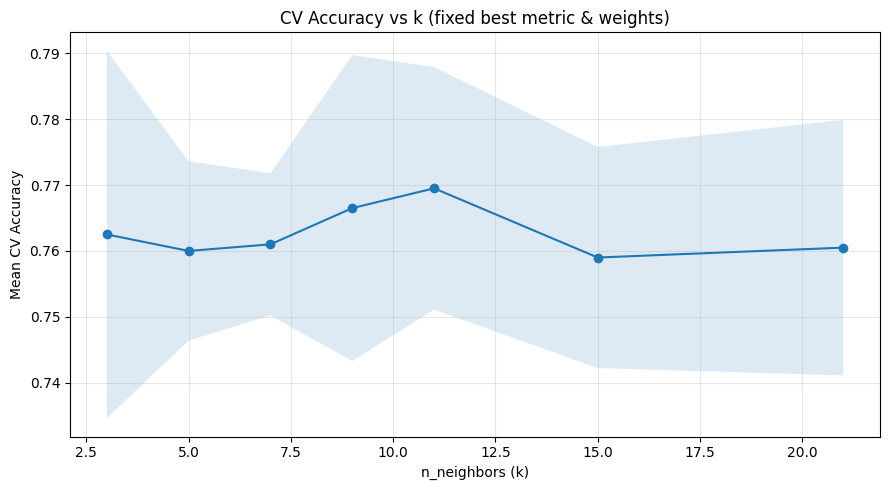


5-fold CV on TRAIN+VAL (best single KNN)...
   fold    cv_acc
0     1  0.758696
1     2  0.750000
2     3  0.778261
3     4  0.753813
4     5  0.810458


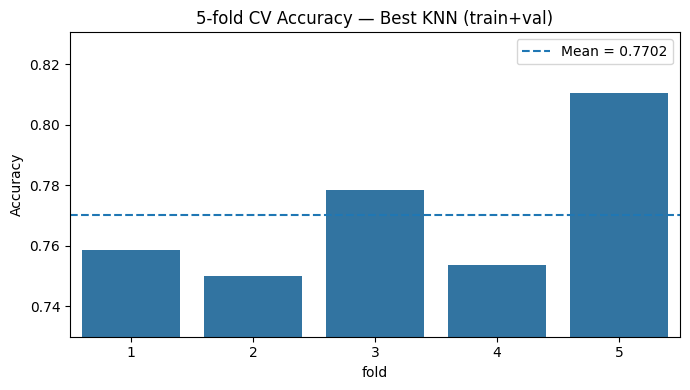


Final Test Performance — Advanced KNN Ensemble
Accuracy : 0.7353
Precision: 0.7014
Recall   : 0.6905
F1-score : 0.6903


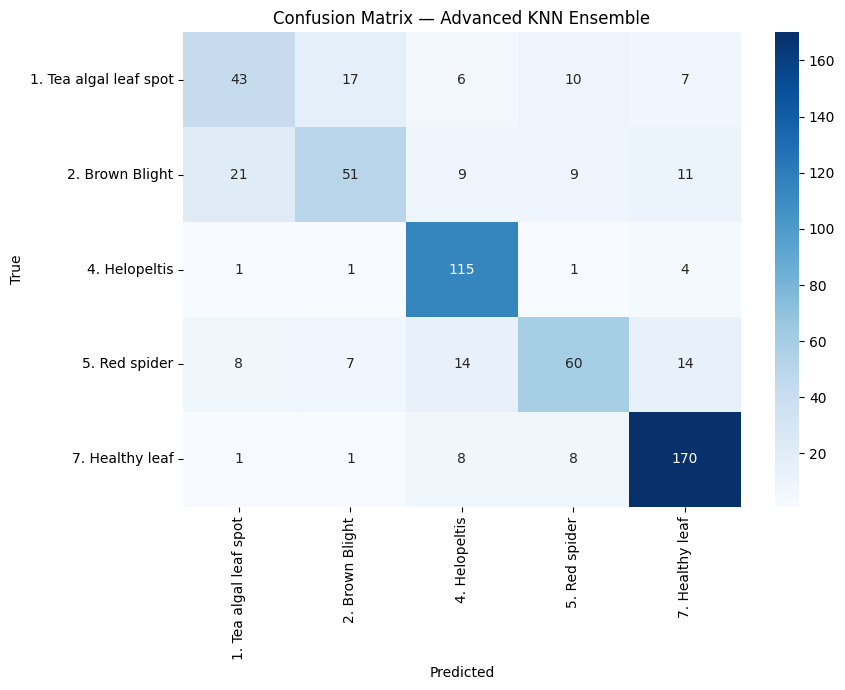

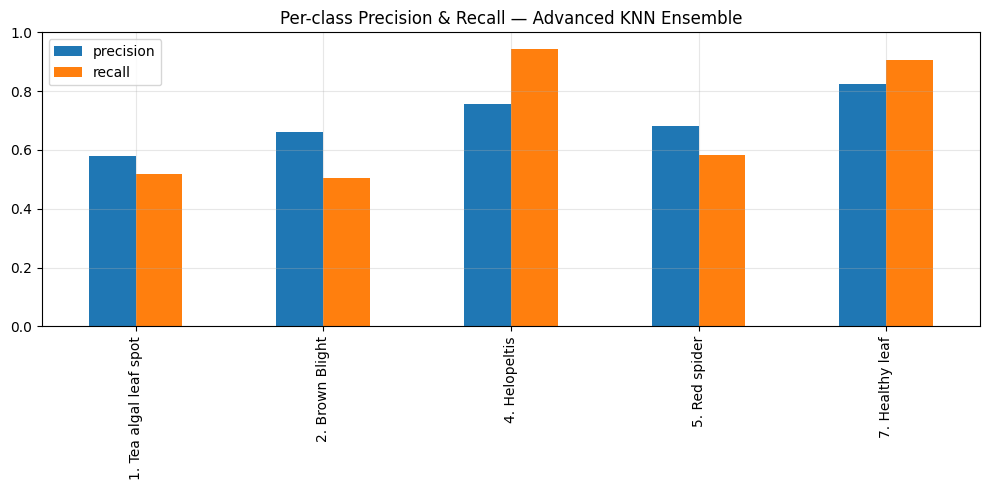


✅ Saved:
  • advanced_enhanced_knn_results.csv
  • advanced_knn_cv_k_curve.csv
  • advanced_knn_cv_folds.csv
  • advanced_knn_model_A.joblib / advanced_knn_model_B.joblib
  • advanced_knn_pca.joblib

Done ✅


In [6]:
# ==============================================================
# TEA LEAF DISEASE DETECTION — ADVANCED ENHANCED KNN (with CV plots)
# 1) MobileNetV2 embeddings → 2) PCA(0.99) → 3) KNN (GridSearchCV)
#    + light augmentation, cosine distance, ensemble (KNN + weighted KNN)
#    + Mean CV accuracy vs k curve (with std band)
#    + 5-fold CV accuracy bar plot
#    + Confusion matrix, per-class P/R plot
#    + Results saved as CSV + models saved as joblib
# ==============================================================

import os, glob, random, gc, json
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score)
import joblib

# ==============================================================
# STEP 1: SETUP
# ==============================================================
np.random.seed(42); tf.random.set_seed(42); random.seed(42)

DATA_ROOT = "/Users/tharukakumarasiri/Desktop/new model training/Final_preprocessed_Dataset"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

IMG_H, IMG_W = 224, 224
BATCH_SIZE = 32

print("="*74)
print("ADVANCED ENHANCED KNN — MobileNetV2 Embeddings + PCA(0.99) + Cosine Distance")
print("="*74)

# ==============================================================
# STEP 2: LOAD IMAGE PATHS & LABELS
# ==============================================================
def gather_paths_and_labels(root_dir):
    paths, labels = [], []
    for cls in sorted(os.listdir(root_dir)):
        cls_dir = os.path.join(root_dir, cls)
        if os.path.isdir(cls_dir):
            for p in glob.glob(os.path.join(cls_dir, "*.jpg")):
                paths.append(p); labels.append(cls)
    return paths, labels

class_names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
print(f"Detected classes ({len(class_names)}): {class_names}")

train_paths, train_labels = gather_paths_and_labels(TRAIN_DIR)
val_paths,   val_labels   = gather_paths_and_labels(VAL_DIR)
test_paths,  test_labels  = gather_paths_and_labels(TEST_DIR)

le = LabelEncoder().fit(class_names)
y_train = le.transform(train_labels)
y_val   = le.transform(val_labels)
y_test  = le.transform(test_labels)
NUM_CLASSES = len(class_names)

print(f"Train: {len(train_paths)} | Val: {len(val_paths)} | Test: {len(test_paths)}")

# ==============================================================
# STEP 3: LOAD & LIGHTLY AUGMENT IMAGES
# ==============================================================
def load_and_augment_images(paths):
    X = np.empty((len(paths), IMG_H, IMG_W, 3), dtype=np.float32)
    for i, path in enumerate(paths):
        img = Image.open(path).convert("RGB").resize((IMG_W, IMG_H))
        # light, label-preserving jitter (10% chance each)
        if random.random() < 0.10:
            img = ImageEnhance.Brightness(img).enhance(random.uniform(0.85, 1.15))
        if random.random() < 0.10:
            img = ImageEnhance.Contrast(img).enhance(random.uniform(0.85, 1.15))
        X[i] = np.asarray(img, dtype=np.float32) / 255.0
    return X

print("\nLoading & augmenting images...")
X_train_img = load_and_augment_images(train_paths)
X_val_img   = load_and_augment_images(val_paths)
X_test_img  = load_and_augment_images(test_paths)

# ==============================================================
# STEP 4: FEATURE EXTRACTION (MobileNetV2, frozen)
# ==============================================================
backbone = MobileNetV2(weights="imagenet", include_top=False, pooling="avg",
                       input_shape=(IMG_H, IMG_W, 3))
backbone.trainable = False

def extract_embeddings(model, X, msg=""):
    X_prep = mobilenet_preprocess((X * 255.).astype(np.float32))
    feats = model.predict(X_prep, batch_size=BATCH_SIZE, verbose=1)
    print(f"{msg} embeddings: {feats.shape}")
    return feats

print("\nExtracting embeddings...")
X_train_emb = extract_embeddings(backbone, X_train_img, "Train")
X_val_emb   = extract_embeddings(backbone, X_val_img,   "Val")
X_test_emb  = extract_embeddings(backbone, X_test_img,  "Test")

del X_train_img, X_val_img, X_test_img
gc.collect()

# ==============================================================
# STEP 5: NORMALIZATION + PCA (retain 99% variance)
# ==============================================================
print("\nNormalizing + PCA (retain 99% variance)...")
X_train_norm = normalize(X_train_emb)
X_val_norm   = normalize(X_val_emb)
X_test_norm  = normalize(X_test_emb)

pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train_norm)
X_val_pca   = pca.transform(X_val_norm)
X_test_pca  = pca.transform(X_test_norm)

print(f"PCA dims: {X_train_pca.shape[1]} (explained variance: {pca.explained_variance_ratio_.sum():.4f})")

# ==============================================================
# STEP 6: (Optional) MERGE TRAIN + VAL FOR FINAL FITS
# ==============================================================
X_trval = np.vstack([X_train_pca, X_val_pca])
y_trval = np.concatenate([y_train, y_val])

# ==============================================================
# STEP 7: GRID (KNN hyperparams)
# ==============================================================
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cosine"]
}
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==============================================================
# STEP 8: GRIDSEARCHCV (5-fold)
# ==============================================================
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, scoring="accuracy", cv=cv5, n_jobs=-1, verbose=1)
grid.fit(X_train_pca, y_train)

best_params = grid.best_params_
best_cv_acc = grid.best_score_
print(f"\nBest Params: {best_params}")
print(f"Best CV Accuracy: {best_cv_acc:.4f}")

# ==============================================================
# STEP 9: MEAN CV ACCURACY vs k  (fixed best metric/weights)  ✅
# ==============================================================
print("\nComputing mean CV accuracy vs k with best metric/weights...")
k_list = [3, 5, 7, 9, 11, 15, 21]
cv_mean, cv_std = [], []

for k in k_list:
    model_k = KNeighborsClassifier(
        n_neighbors=k,
        metric=best_params["metric"],
        weights=best_params["weights"]
    )
    # Use ONLY training split for this analysis (no leakage)
    scores = cross_val_score(model_k, X_train_pca, y_train, cv=cv5, scoring="accuracy", n_jobs=-1)
    cv_mean.append(scores.mean()); cv_std.append(scores.std())

cv_curve_df = pd.DataFrame({"k": k_list, "cv_mean_acc": cv_mean, "cv_std": cv_std})
print("\nCV Accuracy by k (best metric & weights):\n", cv_curve_df)

plt.figure(figsize=(9,5))
plt.plot(k_list, cv_mean, marker="o")
plt.fill_between(k_list,
                 np.array(cv_mean) - np.array(cv_std),
                 np.array(cv_mean) + np.array(cv_std),
                 alpha=0.15)
plt.title("CV Accuracy vs k (fixed best metric & weights)")
plt.xlabel("n_neighbors (k)"); plt.ylabel("Mean CV Accuracy")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Save CV curve
cv_curve_df.to_csv("advanced_knn_cv_k_curve.csv", index=False)

# ==============================================================
# STEP 10: FINAL TRAIN (KNN + Weighted KNN ensemble)
# ==============================================================
knn_a = KNeighborsClassifier(**best_params)  # best from grid
knn_b = KNeighborsClassifier(metric=best_params["metric"],
                             weights=("uniform" if best_params["weights"]=="distance" else "distance"),
                             n_neighbors=best_params["n_neighbors"])
knn_a.fit(X_trval, y_trval)
knn_b.fit(X_trval, y_trval)

# ==============================================================
# STEP 11: 5-FOLD CV (bars) on TRAIN+VAL using best single KNN  ✅
# ==============================================================
print("\n5-fold CV on TRAIN+VAL (best single KNN)...")
cv_scores = cross_val_score(knn_a, X_trval, y_trval, cv=cv5, scoring="accuracy", n_jobs=-1)
cv_bar_df = pd.DataFrame({"fold": np.arange(1, 6), "cv_acc": cv_scores})
print(cv_bar_df)

plt.figure(figsize=(7,4))
sns.barplot(x="fold", y="cv_acc", data=cv_bar_df)
plt.axhline(cv_scores.mean(), ls="--", lw=1.5, label=f"Mean = {cv_scores.mean():.4f}")
plt.title("5-fold CV Accuracy — Best KNN (train+val)")
plt.ylim(max(0.0, cv_scores.min()-0.02), min(1.0, cv_scores.max()+0.02))
plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout(); plt.show()

cv_bar_df.to_csv("advanced_knn_cv_folds.csv", index=False)

# ==============================================================
# STEP 12: EVALUATION (Ensemble) + PLOTS
# ==============================================================
pred_a = knn_a.predict_proba(X_test_pca)
pred_b = knn_b.predict_proba(X_test_pca)
y_pred = np.argmax((pred_a + pred_b)/2, axis=1)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\nFinal Test Performance — Advanced KNN Ensemble")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — Advanced KNN Ensemble")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# Per-class precision/recall plot
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True, zero_division=0)
per_class_df = pd.DataFrame(report).T.loc[class_names, ["precision", "recall"]]
per_class_df.plot(kind="bar", figsize=(10,5))
plt.title("Per-class Precision & Recall — Advanced KNN Ensemble")
plt.ylim(0, 1.0); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# ==============================================================
# STEP 13: SAVE RESULTS + MODELS
# ==============================================================
results = pd.DataFrame({
    "Model": ["Advanced_Enhanced_KNN_Ensemble"],
    "Best_Params": [json.dumps(best_params)],
    "Grid_CV_Accuracy": [best_cv_acc],
    "CV5_Mean_Acc_TrainVal": [cv_scores.mean()],
    "CV5_Std_TrainVal": [cv_scores.std()],
    "Test_Accuracy": [acc],
    "Precision": [prec],
    "Recall": [rec],
    "F1_Score": [f1],
    "PCA_Dim": [X_train_pca.shape[1]]
})
results.to_csv("advanced_enhanced_knn_results.csv", index=False)

cv_curve_df.to_csv("advanced_knn_cv_k_curve.csv", index=False)   # (already saved above, safe to overwrite)
cv_bar_df.to_csv("advanced_knn_cv_folds.csv", index=False)

joblib.dump(knn_a, "advanced_knn_model_A.joblib")
joblib.dump(knn_b, "advanced_knn_model_B.joblib")
joblib.dump(pca, "advanced_knn_pca.joblib")

print("\n✅ Saved:")
print("  • advanced_enhanced_knn_results.csv")
print("  • advanced_knn_cv_k_curve.csv")
print("  • advanced_knn_cv_folds.csv")
print("  • advanced_knn_model_A.joblib / advanced_knn_model_B.joblib")
print("  • advanced_knn_pca.joblib")
print("\nDone ✅")